In [3]:
import numpy as np
from PIL import Image
import sys, os
import matplotlib.pyplot as plt
from utils import *
from plot_util import *
import pickle, random, time
import theano
import theano.tensor as T
from numpy.linalg import norm
theano.config.floatX = 'float32'
#theano.config.optimizer = 'None'
theano.config.exception_verbosity = 'high'
#theano.config.warn_float64 = 'raise'
%matplotlib inline

# Phase Learning
## Leaky intergrator system as MCMC and relation to energy models
   Under certain conditions there is a link between the dynamics of system of leaky integrate-and-fire neurons and statistical energ-based models. The network and the energy-based model are both trained to calculate $P(h|x)$. 
   
### Defining the System

$s_{t} = (x, h, y)$ is the state of the system at time t and $s_{t, i}$ represents the $i$-th unit. $x_{t} \in s_{t}$  represents the visable units and $h_{t} \in s_{t}$ represents the hidden units. The system evolves according to the following dynamics:

$$h_{t+1}=f(s_{t},\eta_{t})=h_{t}+\epsilon (R_{h}(s_t + \eta_{t}) - h_{t})$$

Here $f$ is a function that maps the current state and system noise to the next hidden unit state. $R$ is a function that maps the current system noisy-state to the target value for $h$. $\epsilon$ is the system frame rate or when viewed from the in the differential equation form $\tau \dot{h} = R_{h}(s+\eta)-h$, $\epsilon = \frac{1}{\tau}$, i.e, $\epsilon$ is the inverse of the time consant $\tau$.

$$\frac{ds_{i}}{dt} = \frac{R_{i}(s + \eta) - s_{i}}{\tau}$$

The noise, $\eta$, is what allows the system behave as a Monte Carlo Markov Chain (MCMC).
   
### Link to Energy-Based Models

It has been shown that if the energy of a probabilistic model is $P(s) \propto e^{-E(s)}$ the difference between the target state and current state is $R(s) -s \propto \frac{\delta log P(s)}{\delta s} = -\frac{\delta E(s)}{\delta s}$.

$$\frac{ds}{dt} = -\frac{1}{\tau} \frac{dE}{ds}(\theta, s) = \frac{R_{i}(s) - s}{\tau}$$


$$E(\theta,s)=\frac{1}{2} \sum_{i} s^{2}_{i} - \frac{1}{2} \sum_{i \neq j} W_{i,j} \rho(s_{i}) \rho(s_{j}) - \sum_{i} b_{i}\rho(s_{i})$$

After differntiating the energy equation and assuming symetrical weights

$$R_{i}(s)=\rho^{'}(s_{i}) (\sum_{i \neq j} W_{i,j} \rho(s_{j}) + \sum_{i} b_{i})$$



$$\frac{dW_{ij}}{dt} \propto \rho(s_{i}) \frac{d \rho(s_{j})}{dt}$$

$$\frac{dW_{ij}}{dt} \propto \rho(s_{i}) \frac{d \rho(s_{j})}{dt} + \rho(s_{j}) \frac{d \rho(s_{i})}{dt} = \frac{d}{dt} \rho(s_{i}) \rho(s_{j})$$

### Expanding the Energy Function

$$C_{\beta}(x,y) = \frac{1}{2}\beta_{x}\Vert \hat{x} - x \Vert^{2} + \frac{1}{2} \beta_{y} \Vert \hat{y} - y \Vert^{2}$$

Where $C_{\beta}(x,y)$ is an additional term added to the energy function that controls the influence of the visable units on the system. $\beta_{i}$ varies from $(0,\infty)$. $\hat{x}$ and $
\hat{y}$ represent the true data distribution. 

$$F(\theta, s, \beta_{x}, \beta_{y}, x, y) = E(\theta, s) + C(\beta_{x}, \beta_{y}, x, y)$$

When it is assumed that $x$ is always clamped the total energy becomes

$$F(\theta, h, \beta_{y}, y) = E(\theta, h, y) + \beta_{y}\Vert \hat{y} - y \Vert$$

With $x$ clamped, $\beta_{x} = \infty$, and $\beta_{y}=0$ the system is in the negative phase. With $\beta_{y} > 0$ the system is in the positive phase. 

$$\frac{ds_{i}}{dt} = \frac{R_{i}(s) + \beta_{y} \hat{y}_{i} - s_{i}}{\tau}$$

Contrastive hebbian learning can be performed between the positive and negatve phases, $s^{+}$ and $s^{-}$.

$$\Delta W_{ij} \propto \rho(s_{i}^{+}) \rho(s_{j}^{+})- \rho(s_{i}^{-}) \rho(s_{j}^{-})$$

This method is different from the originally proposed contrastive Hebbian learning algorithm by having an adjustible gain parameter for the positive phase. This allows the system to settle to the positive phase fixed point in fewer iterations. This model also incorperates full feedback where the original algorithim uses a scaling parameter for feeback.  

In [34]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('mnist.pkl')
#train_x = whiten(train_x)

In [23]:
class CHLayer:
    def __init__(self, xf, y, y_neg, y_pos, Wf, b, xb=None, Wb=None, Wl= None, Wz=None, activation=lin):        
        self.xf = xf
        self.xb = xb
        self.y = y
        self.y_neg = y_neg
        self.y_pos = y_pos
        self.Wf = Wf
        self.Wb = Wb
        self.b = b
        
        if Wb is None and b is not None:            
            self.output = activation(T.dot(self.xf, self.Wf) + self.b)
        elif Wb is None and b is None:
            self.output = activation(T.dot(self.xf, self.Wf))
        elif b is None:
            self.output = activation(T.dot(self.xf, self.Wf) + T.dot(self.xb, self.Wb.T))
        else:
            self.output = activation(T.dot(self.xf, self.Wf) + T.dot(self.xb, self.Wb.T) + self.b)

def run_exp(dims=[500], fr=0.5, lr=[10**-1, 10**-2], batch_size=10, tol=10**-3, ni=10, pi=2, bias_h=True,
                 X=train_x, Y=train_y, nsamples=50000, epochs=1, learning_rule=step, activation=thsig):
    
    plotres = nsamples*epochs/50 if nsamples*epochs >= 50 else 1
    neg_iter = int(ni*fr**-1)    
    pos_iter = int(pi*fr**-1)
    print 'fr: {}, batch_size: {}, epochs: {}, plotres: {} samples'.format(fr, batch_size, epochs, plotres)
    print 'neg iter: {}, pos iter: {}'.format(neg_iter, pos_iter)
    
    
    #get IO dims
    ni = X.shape[1]
    no = max(Y) + 1
    dims = [ni] + dims        
    dims += [no]
    nbatches = nsamples/batch_size
    print 'dims {}'.format(dims)
    print 'lrs {}'.format(lr)
    print 'learning rule: {}'.format(learning_rule.__name__)
    
    #init training set vars
    Y_labels = sharedX(Y, name='Y')
    Yoh = sharedX(onehot(Y), name= 'Yoh')
    X = sharedX(X, name='X')
    x = T.fmatrix('x')
    y = T.fvector('y')
    yoh = T.fmatrix('yoh')
    i = T.iscalar('i')
    
    #create layer vars and weights
    lvars = [sharedX(rand(batch_size, n), name='y_' + str(l)) for l, n in enumerate(dims[1:])]#layer var
    x_neg_vars = [x] + lvars #feedforward list
    neg_vars = [sharedX(rand(batch_size, n), name='y_n_' + str(l)) for l, n in enumerate(dims[1:])] #negative phase var
    pos_vars = [sharedX(rand(batch_size, n), name='y_p_' + str(l)) for l, n in enumerate(dims[1:])] #positive phase var
    weights = [sharedX(rand_ortho(dims[l], dims[l+1])/2, name='w_' + str(n)) for n, l in enumerate(range(len(dims) - 1))] #weghts
    bias = [sharedX(rand(n), name='b_' + str(l)) for l, n in enumerate(dims[1:])]
    
    
    #create and link layers   
    layers = []
    for l in range(len(dims) - 2):
        layers += [CHLayer(xf=x_neg_vars[l],
                           xb=lvars[l+1],
                           y=lvars[l],
                           y_neg=neg_vars[l],
                           y_pos=pos_vars[l],
                           Wf=weights[l],
                           Wb=weights[l+1],
                           b=bias[l] if bias_h else None,
                           activation=activation)]
    #last layer
    layers += [CHLayer(xf=lvars[-2],
                       y=lvars[-1],
                       y_neg=neg_vars[-1],
                       y_pos=pos_vars[-1],
                       Wf=weights[-1],
                       b=bias[-1],
                       activation=activation)]
            
    #create negative phase function
    neg_updates = OrderedDict()
    neg_outputs = [l.output.mean(axis=0) for l in layers]
    for l in layers:
        neg_updates[l.y] = (1. - fr)*l.y + fr*l.output
        neg_updates[l.y_neg] = l.y
    neg_phase = theano.function([i], 
                                neg_outputs,
                                givens={x: X[i*batch_size : (i+1)*batch_size]},
                                updates = neg_updates)
    
    # create positive phase function
    pos_updates = OrderedDict()
    pos_outputs = [l.output.mean(axis=0) for l in layers]
    for l in layers[:-1]:
        pos_updates[l.y] = (1. - fr)*l.y + fr*l.output
        pos_updates[l.y_pos] = l.y
    #last layer update includes positive phase output error
    pos_updates[layers[-1].y] = (1. - fr)*layers[-1].y + fr*yoh
    pos_updates[layers[-1].y_pos] = layers[-1].y
    pos_phase = theano.function([i],
                                pos_outputs, 
                                givens={x: X[i*batch_size : (i+1)*batch_size],
                                        yoh: Yoh[i*batch_size : (i+1)*batch_size]},
                                updates = pos_updates)
    
    #update params
    param_updates = OrderedDict()
    for l, layer in enumerate(layers):
        param_grad = OrderedDict()
        if l == 0:
            x_term = T.repeat(T.reshape(x, (batch_size, X.shape[1], 1)), layer.y.shape[1], axis=2)
            pos_term = T.repeat(T.reshape(layer.y_pos, (batch_size, 1, layer.y.shape[1])), X.shape[1], axis=1)
            neg_term = T.repeat(T.reshape(layer.y_neg, (batch_size, 1, layer.y.shape[1])), X.shape[1], axis=1)
            param_grad[layer.Wf] = T.mean(x_term*pos_term - x_term*neg_term, axis=0)
            if layer.b is not None:
                param_grad[layer.b] = layer.b*T.mean((layer.y_pos-layer.y_neg), axis=0)
            for param, grad in learning_rule(param_grad, lr[l]).items():
                param_updates[param] = grad
        else:
            i_pos = T.repeat(T.reshape(layers[l-1].y_pos, (batch_size, layers[l-1].y.shape[1], 1)), layer.y.shape[1], axis=2)
            j_pos = T.repeat(T.reshape(layer.y_pos, (batch_size, 1, layer.y.shape[1])), layers[l-1].y.shape[1], axis=1)
            i_neg = T.repeat(T.reshape(layers[l-1].y_neg, (batch_size, layers[l-1].y.shape[1], 1)), layer.y.shape[1], axis=2)
            j_neg = T.repeat(T.reshape(layer.y_neg, (batch_size, 1, layer.y.shape[1])), layers[l-1].y.shape[1], axis=1)
            param_grad[layer.Wf] = T.mean(i_pos*j_pos - i_neg*j_neg, axis=0)
            if layer.b is not None:
                param_grad[layer.b] = layer.b*T.mean((layer.y_pos - layer.y_neg), axis=0)
            for param, grad in learning_rule(param_grad, lr[l]).items():
                param_updates[param] = grad

    param_update = theano.function([i],
                               param_updates.values(),
                               givens={x: X[i*batch_size : (i+1)*batch_size]},
                               updates=param_updates)

    #create loss and error function
    P = sfmx(layers[-1].y_neg)
    cost = NLL_batch(P, yoh)
    err = error(predict_batch(P), y)
    loss = theano.function([i],
                      [cost, err], 
                      givens={y: Y_labels[i*batch_size : (i+1)*batch_size],
                      yoh: Yoh[i*batch_size : (i+1)*batch_size]})

    #stats
    stats = {'Deltas': [],
             'Deltas avg by vec': [],
             'Deltas norm by vec': [],
             'Activations': {'Neg': [], 'Pos': []},
             'Activations by vec': {'Neg': [], 'Pos': []},
             'nll': [],
             'err': [],
             'yex': {'Neg': [], 'Pos': []},
             'steps': [],
             'step diffs': [],
             'delta_avg': []}
    
    for e in range(1, epochs + 1):
        t = time.time()
        print e
        y_prev = np.asarray([l.y.get_value().mean(axis=0) for l in layers])
        for sample in range(nbatches):
            #Negative Phase
            step = 0
            for n in range(neg_iter):
                step += 1
                yex_neg = np.asarray(neg_phase(sample))
                
                diffs = [(np.sum((l[0] - l[1])**2)/np.sum(l[1])) for l in zip(list(yex_neg), list(y_prev))]
                if np.sum(diffs) <= tol:
                    break
                    

            #Positive Phase
            for n in range(pos_iter):
                yex_pos = pos_phase(sample)

            #param updates
            if (sample*batch_size + (1-e)*nsamples)%plotres == 0:                
                deltas = np.asarray(param_update(sample))
                dnorms = [norm(d, axis=0) if len(d.shape) > 1 else d for d in deltas ]
                stats['Deltas'] += [[[d.mean() for d in dnorms],
                                      [d.std() for d in dnorms]]]
                stats['delta_avg'] += [[[d.mean() for d in deltas],
                                        [d.std() for d in deltas]]]
                
                stats['Deltas norm by vec'] += [[norm(d, axis=0) if len(d.shape) > 1 else norm(d) for d in deltas]]

                stats['Deltas avg by vec'] += [[d.mean(axis=0) if len(d.shape) > 1 else d.mean() for d in deltas]]

                stats['Activations']['Neg'] += [[[l.y_neg.get_value().mean() for l in layers],
                                                       [l.y_neg.get_value().std() for l in layers]]]
                stats['Activations']['Pos'] += [[[l.y_pos.get_value().mean() for l in layers],
                                                       [l.y_pos.get_value().std() for l in layers]]]
                stats['Activations by vec']['Neg'] += [[l.y_neg.get_value().mean(axis=0) for l in layers]]
                stats['Activations by vec']['Pos'] += [[l.y_pos.get_value().mean(axis=0) for l in layers]]
                stats['yex']['Neg'] += [[[var.mean() for var in yex_neg],
                                            [var.std() for var in yex_neg]]]
                stats['yex']['Pos'] += [[[var.mean() for var in yex_pos],
                                            [var.std() for var in yex_pos]]]

                lossvars = loss(sample)

                stats['nll'] += [lossvars[0]]
                stats['err'] += [lossvars[1]]
                stats['steps'] += [step]
                stats['step diffs'] += [diffs]

            else:
                param_update(sample)

        print int((time.time()-t)/60), ' min', int(time.time()-t), ' sec'
        pickle.dump((weights, bias, stats), open('params_chl.pkl', 'wb'))
    return weights, bias, stats, layers, yex_neg

fr: 0.5, batch_size: 100, epochs: 1, plotres: 1000 samples
neg iter: 20, pos iter: 4
dims [784, 64, 10]
lrs [0.01, 0.005]
learning rule: adam_norm
1
0  min 33  sec


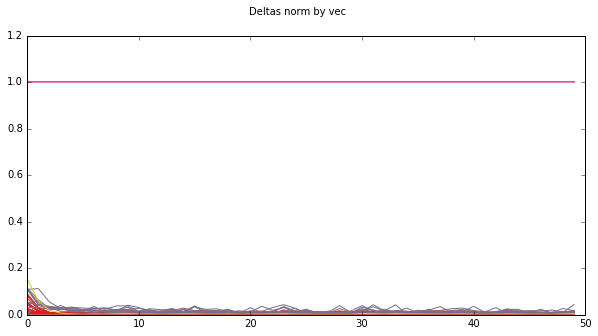

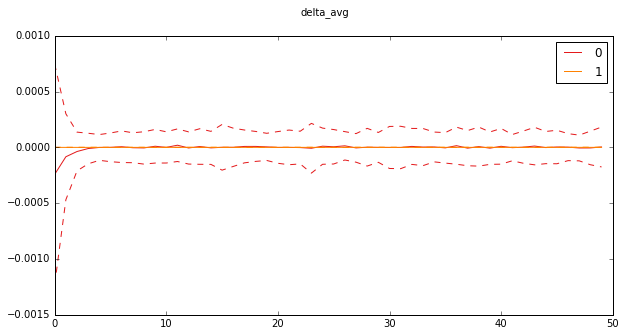

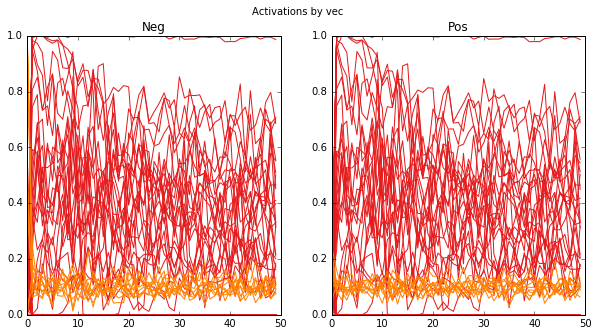

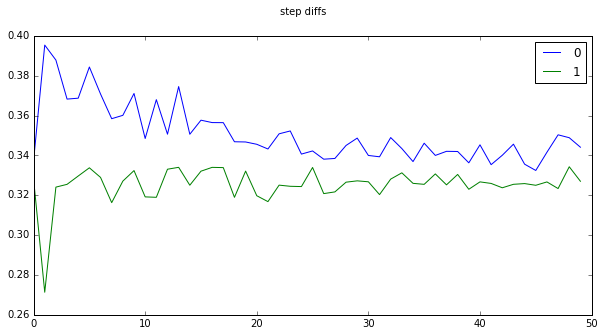

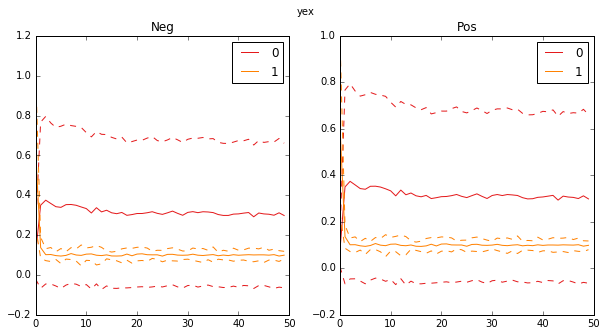

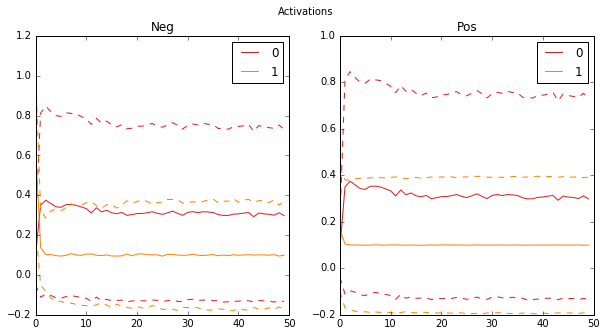

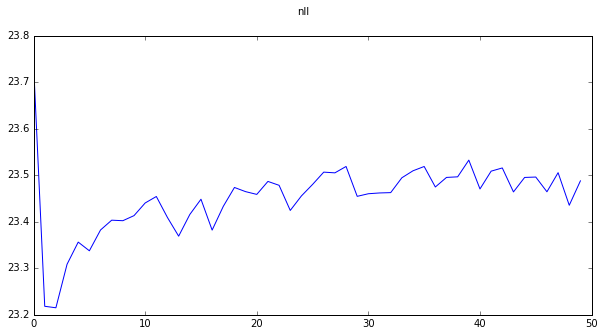

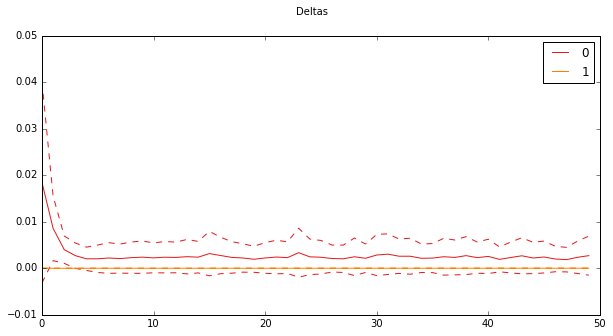

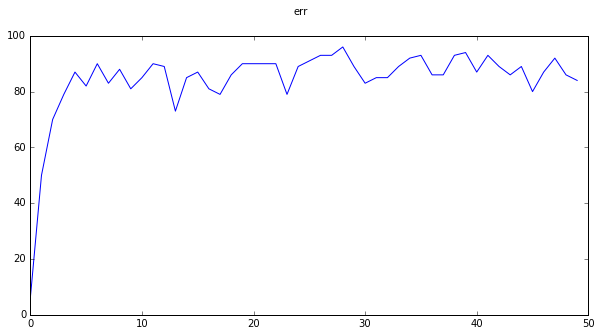

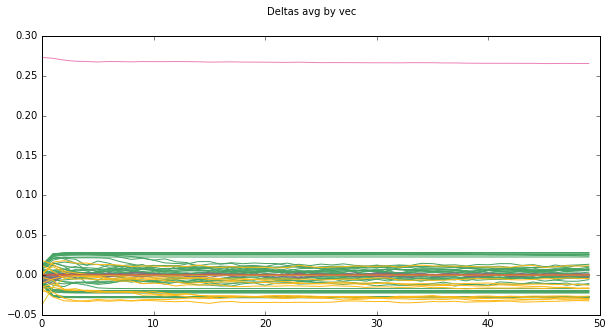

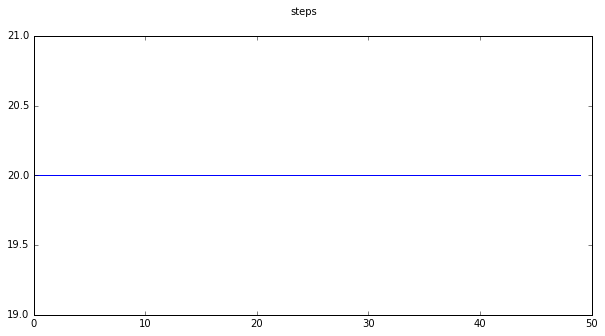

In [26]:
weights, bias, stats, layers, yex_neg = run_exp(nsamples=50000,
                                                fr=0.5,
                                                dims=[64],
                                                epochs=1,
                                                lr=[0.01, 0.005],
                                                ni=10,
                                                pi=2,
                                                bias_h=False,
                                                learning_rule=adam_norm,
                                                batch_size=100)
plot_stats(stats)

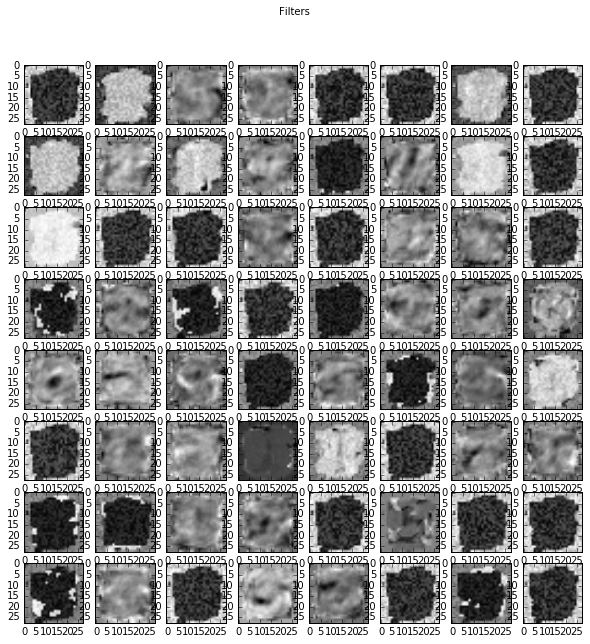

In [27]:
plot_filters(weights[0].get_value()[:, :64])

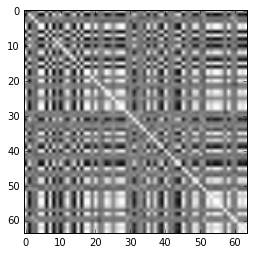

In [39]:
#plot param inner product matrix
w1 = weights[0].get_value()
plt.imshow(w1.T.dot(w1), cmap=plt.cm.gray)